# Playground Series - S4E3 | Steel Plate Defect prediction


## Preparing train set

In [27]:
import pandas as pd
import numpy as np
from sklearn import model_selection
path = 'input/'

TARGET = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

if __name__ == "__main__":
    # Training data is in the "train.csv" and "faults.csv" files
    train_data = pd.read_csv(path + 'train.csv')
    original_data = pd.read_csv(path + 'faulty-steel-plates/faults.csv')
    train_data.drop('id', axis=1, inplace=True)
    train_data = pd.concat([train_data, original_data], axis=0)

    # drop mult label data points
    train_data = train_data[train_data[TARGET].sum(axis=1) <= 1]
    train_data['Outside_Global_Index'] = np.where(train_data['Outside_Global_Index']==0.7, 0.5, train_data['Outside_Global_Index'])

    train_data['target'] = np.argmax(train_data[TARGET].values, axis=1) + 1
    train_data.loc[train_data[TARGET].sum(axis=1) == 0, 'target'] = 0
    train_data.drop(TARGET, axis=1, inplace=True)

    # we create a new column called kfold and fill it with -1
    train_data['kfold'] = -1

    # the next step is to randomize the rows of the data
    train_data = train_data.sample(frac=1).reset_index(drop=True)

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=train_data, y=train_data['target'].values)):
        train_data.loc[v_, 'kfold'] = f
    
    # save the new csv with kfold column
    train_data.to_csv(path + 'train_folds.csv', index=False)


    

    

## Classification of Steel Plate Defect dataset with tree-base models (baseline)

* [Extreme Gradient Booster (Random Forest)](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

* [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)

* [CatBoost](https://catboost.ai/)

### Read dataset and check the distribution of target variables

In [1]:
import pandas as pd

df = pd.read_csv('input/train_folds.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21139 entries, 0 to 21138
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21139 non-null  int64  
 1   X_Maximum              21139 non-null  int64  
 2   Y_Minimum              21139 non-null  int64  
 3   Y_Maximum              21139 non-null  int64  
 4   Pixels_Areas           21139 non-null  int64  
 5   X_Perimeter            21139 non-null  int64  
 6   Y_Perimeter            21139 non-null  int64  
 7   Sum_of_Luminosity      21139 non-null  int64  
 8   Minimum_of_Luminosity  21139 non-null  int64  
 9   Maximum_of_Luminosity  21139 non-null  int64  
 10  Length_of_Conveyer     21139 non-null  int64  
 11  TypeOfSteel_A300       21139 non-null  int64  
 12  TypeOfSteel_A400       21139 non-null  int64  
 13  Steel_Plate_Thickness  21139 non-null  int64  
 14  Edges_Index            21139 non-null  float64
 15  Em

In [2]:
df['target'].value_counts()

target
7    7213
6    5163
3    3802
1    1623
2    1340
0     818
4     640
5     540
Name: count, dtype: int64

In [33]:
def model_assess(model, title='Default'):
    model.fit(X_train, y_train)
    # Predict class probabilities
    y_proba = model.predict_proba(X_test)

    # Compute the AUC for each class and take the average
    average_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print(f'{title} Average AUC: {average_auc}')
    return average_auc

    


In [7]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train.drop(['target', 'kfold'], axis=1)
    y_train = df_train['target']

    X_test = df_test.drop(['target', 'kfold'], axis=1)
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')
    

Processing fold 0
XGBoost Average AUC: 0.8586832118510552
Execution time for XGBoost: 6.90 seconds
CatBoost Average AUC: 0.8649960107272939
Execution time for CatBoost: 17.16 seconds
LightGBM Average AUC: 0.8598581668227699
Execution time for LightGBM: 7.85 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.8546527862446336
Execution time for XGBoost: 4.48 seconds
CatBoost Average AUC: 0.8625416418390057
Execution time for CatBoost: 14.44 seconds
LightGBM Average AUC: 0.8581122899913534
Execution time for LightGBM: 6.95 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.8522447318088513
Execution time for XGBoost: 3.20 seconds
CatBoost Average AUC: 0.8533285237635493
Execution time for CatBoost: 11.50 seconds
LightGBM Average AUC: 0.8604471048523936
Execution time for LightGBM: 8.60 seconds
--------------------------------------------------
Processing fold 3
XGBoost Average AUC: 0.85510709

Analysing the cross-fold validation, LightGBM and CatBoost had the best overall results.

## Applying All Relevant Features Selections (([ARFS](https://github.com/ThomasBury/arfs))) and Boruta to the dataset

### GrootCV



























Repeated k-fold: 100%|██████████| 25/25 [11:57<00:00, 28.69s/it]


The selected features: ['Outside_X_Index' 'Edges_Y_Index']
The agnostic ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1]
The naive ranking: ['Edges_Y_Index', 'Outside_X_Index', 'LogOfAreas', 'Length_of_Conveyer', 'Luminosity_Index', 'Empty_Index', 'Orientation_Index', 'Edges_Index', 'Log_X_Index', 'ShadowVar16', 'ShadowVar17', 'Edges_X_Index', 'ShadowVar2', 'Minimum_of_Luminosity', 'ShadowVar15', 'ShadowVar18', 'ShadowVar1', 'ShadowVar19', 'ShadowVar10', 'Log_Y_Index', 'ShadowVar11', 'Pixels_Areas', 'Maximum_of_Luminosity', 'ShadowVar14', 'ShadowVar12', 'ShadowVar13', 'Outside_Global_Index']


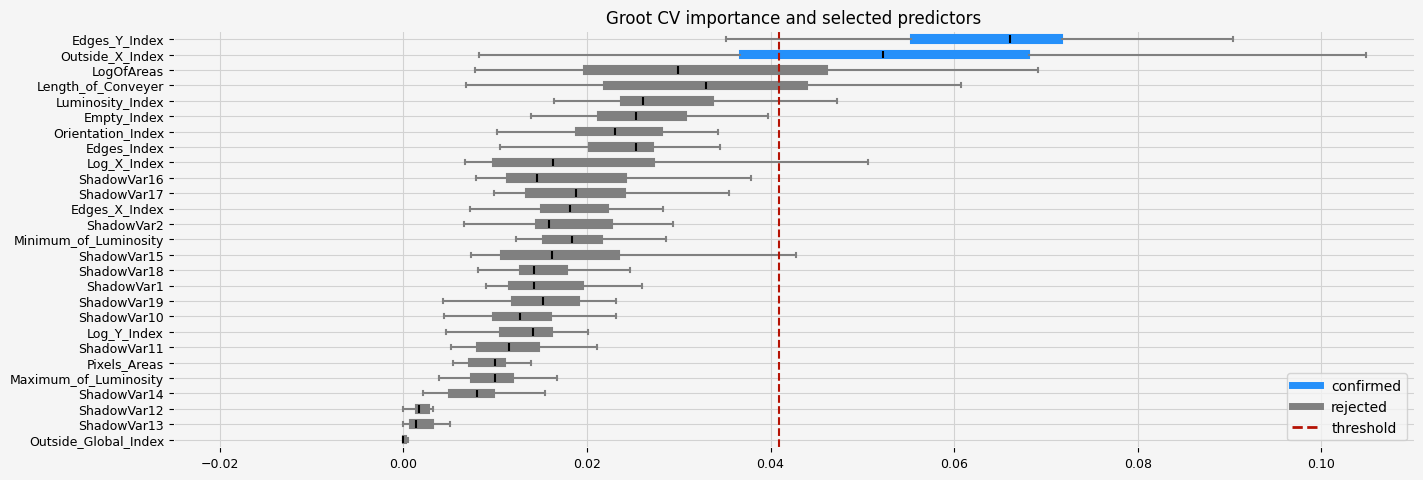

In [9]:
import pandas as pd
import lightgbm as lgb
import arfs.feature_selection.allrelevant as arfsgroot
import matplotlib as mpl
import matplotlib.pyplot as plt
import json

from arfs.benchmark import highlight_tick

%matplotlib inline

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['target', 'kfold'], axis=1)
y = df['target']

model = lgb.LGBMClassifier(random_state=42, device='gpu', verbose=0)

grootcv_feat_selector = arfsgroot.GrootCV(objective='multiclass', cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=False, n_jobs=0, lgbm_params={'device': 'gpu', 'gpu_device_id': 1})
grootcv_feat_selector.fit(X, y, sample_weight=None)

print(f"The selected features: {grootcv_feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {grootcv_feat_selector.ranking_}")
print(f"The naive ranking: {grootcv_feat_selector.ranking_absolutes_}")
fig = grootcv_feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

grootcv_selected_features = grootcv_feat_selector.get_feature_names_out()

json_file_path = 'groot_cv_selected_features.json'
with open(json_file_path, 'w') as f:
    json.dump(grootcv_selected_features.tolist(), f)

In [20]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

json_file_path = 'groot_cv_selected_features.json'

# Load the selected features from the JSON file
with open(json_file_path, 'r') as json_file:
    selected_features = json.load(json_file)

print(f'selected features from GrootCV: {selected_features}')
for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train[selected_features]
    y_train = df_train['target']

    X_test = df_test[selected_features]
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')

selected features from GrootCV: ['Outside_X_Index', 'Edges_Y_Index']
Processing fold 0
XGBoost Average AUC: 0.7411524110782949
Execution time for XGBoost: 3.48 seconds
CatBoost Average AUC: 0.7518728193846091
Execution time for CatBoost: 14.11 seconds
LightGBM Average AUC: 0.7450310543399359
Execution time for LightGBM: 6.99 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.7398853804452838
Execution time for XGBoost: 3.10 seconds
CatBoost Average AUC: 0.7513501938649909
Execution time for CatBoost: 9.82 seconds
LightGBM Average AUC: 0.7424953294433683
Execution time for LightGBM: 6.67 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.7513178336479928
Execution time for XGBoost: 3.99 seconds
CatBoost Average AUC: 0.7540789380917885
Execution time for CatBoost: 12.77 seconds
LightGBM Average AUC: 0.7521410635198145
Execution time for LightGBM: 7.14 seconds
--------------------------------

### Leshy

c:\Users\Rafael\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Leshy iteration:  90%|█████████ | 9/10 [00:15<00:01,  1.78s/it]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	14
Tentative: 	1
Rejected: 	12
All relevant predictors selected in 00:00:16.00
The selected features are: ['X_Minimum' 'X_Maximum' 'Minimum_of_Luminosity' 'Maximum_of_Luminosity'
 'Length_of_Conveyer' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_Y_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index'], <class 'numpy.ndarray'>
The agnostic ranking: [ 1  1  5  9  4 11  6  3  1  1  1 10 13  1  1  1  1  1  2  1 14  7 12  1
  1  1  7], <class 'numpy.ndarray'>
The naive ranking: ['Steel_Plate_Thickness', 'Length_of_Conveyer', 'Minimum_of_Luminosity', 'Edges_Index', 'Empty_Index', 'Outside_X_Index', 'X_Minimum', 'X_Maximum', 'Orientation_Index', 'Luminosity_Index', 'Edges_Y_Index', 'Square_Index', 'Log_Y_Index', 'Maximum_of_Luminosity', 'Edges_X_Index', 'Sum_of_Luminosity', 'Pixels_Areas', 'Y_Minimum', 'Y_Perimeter', 'SigmoidOfAreas', 'LogOfAreas', 'Y_Maximum'

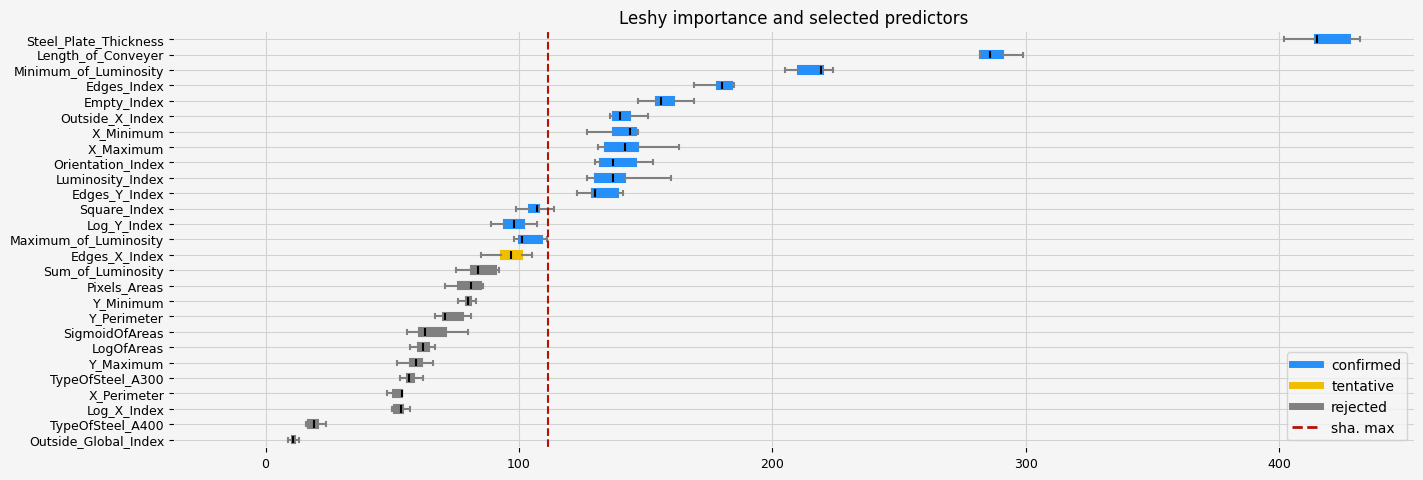

In [1]:
import lightgbm as lgb
import pandas as pd
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
import matplotlib.pyplot as plt
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['target', 'kfold'], axis=1)
y = df['target']

model = lgb.LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native")
feat_selector.fit(X, y, sample_weight=None)
print(f'The selected features are: {feat_selector.selected_features_}, {type(feat_selector.selected_features_)}')
print(f'The agnostic ranking: {feat_selector.ranking_}, {type(feat_selector.ranking_)}')
print(f'The naive ranking: {feat_selector.ranking_absolutes_}, {type(feat_selector.ranking_absolutes_)}')
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [3]:
import json

leshy_selected_features = feat_selector.get_feature_names_out()

json_file_path = 'leshy_selected_features.json'
with open(json_file_path, 'w') as f:
    json.dump(leshy_selected_features.tolist(), f)

In [6]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

json_file_path = 'leshy_selected_features.json'

# Load the selected features from the JSON file
with open(json_file_path, 'r') as json_file:
    selected_features = json.load(json_file)

print(f'selected features from GrootCV: {selected_features}')
for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train[selected_features]
    y_train = df_train['target']

    X_test = df_test[selected_features]
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')

selected features from GrootCV: ['X_Minimum', 'X_Maximum', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_Y_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index']
Processing fold 0


c:\Users\Rafael\miniconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:58:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Average AUC: 0.8495153218968916
Execution time for XGBoost: 4.94 seconds
CatBoost Average AUC: 0.8562202164851223
Execution time for CatBoost: 17.88 seconds
LightGBM Average AUC: 0.8573730847580081
Execution time for LightGBM: 19.57 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.8529276765014286
Execution time for XGBoost: 3.86 seconds
CatBoost Average AUC: 0.8614223802534742
Execution time for CatBoost: 14.73 seconds
LightGBM Average AUC: 0.8605449716669614
Execution time for LightGBM: 17.16 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.8515708083872318
Execution time for XGBoost: 4.22 seconds
CatBoost Average AUC: 0.8528774703529343
Execution time for CatBoost: 15.62 seconds
LightGBM Average AUC: 0.8566120933277718
Execution time for LightGBM: 17.17 seconds
--------------------------------------------------
Processing fold 3
XGBoost Average AUC: 0.8526736794731189
Execut

### Boruta

In [32]:
import pandas as pd
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import json

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['target', 'kfold'], axis=1)
y = df['target']

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

model = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=42)
feat_selector.fit(X.values, y.values)

cols_selected = feat_selector.support_.tolist()

selected_features = X.columns[cols_selected].tolist()
print(f'The selected features are: {selected_features}')

json_file_path = 'boruta_selected_features.json'
with open(json_file_path, 'w') as f:
    json.dump(selected_features, f)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100


BorutaPy finished running.

Iteration: 	41 / 100
Confirmed: 	21
Tentative: 	0
Rejected: 	6
The selected features are: ['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosi

In [34]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

json_file_path = 'boruta_selected_features.json'

# Load the selected features from the JSON file
with open(json_file_path, 'r') as json_file:
    selected_features = json.load(json_file)

print(f'selected features from GrootCV: {selected_features}')
for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train[selected_features]
    y_train = df_train['target']

    X_test = df_test[selected_features]
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')

selected features from GrootCV: ['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']
Processing fold 0


c:\Users\Rafael\miniconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Average AUC: 0.856711170447211
Execution time for XGBoost: 5.39 seconds
CatBoost Average AUC: 0.8601851024972558
Execution time for CatBoost: 19.13 seconds
LightGBM Average AUC: 0.8559686340674829
Execution time for LightGBM: 22.97 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.8542794580945372
Execution time for XGBoost: 5.16 seconds
CatBoost Average AUC: 0.8602272411723837
Execution time for CatBoost: 16.81 seconds
LightGBM Average AUC: 0.8602832074969413
Execution time for LightGBM: 21.46 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.8505103442376933
Execution time for XGBoost: 5.36 seconds
CatBoost Average AUC: 0.8551912935221624
Execution time for CatBoost: 17.16 seconds
LightGBM Average AUC: 0.8596158903640623
Execution time for LightGBM: 21.03 seconds
--------------------------------------------------
Processing fold 3
XGBoost Average AUC: 0.8542765349500159
Executi

Although the models had a improvement in time-processing, it didn't improve the AUC score.

## Fine-tuning the hyperParameters with [FLAML](https://microsoft.github.io/FLAML/)

In [35]:
import pandas as pd
from flaml import AutoML

df = pd.read_csv('input/train_folds.csv')

df_train = df[df.kfold != 0].reset_index(drop=True)
df_test = df[df.kfold == 0].reset_index(drop=True)

X_train = df_train.drop(['target', 'kfold'], axis=1)
y_train = df_train['target']

X_test = df_test.drop(['target', 'kfold'], axis=1)
y_test = df_test['target']

automl = AutoML()
settings = {
    'time_budget': 300,  # in seconds
    'metric': 'roc_auc_ovr',
    'task': 'classification',
    'estimator_list': ['lgbm', 'xgboost', 'catboost']
}

automl.fit(X_train=X_train, y_train=y_train, **settings)
print('Best hyperparmeter config:', automl.best_config)
print('Best ROC AUC on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print(automl.model.estimator)

[flaml.automl.logger: 04-09 09:31:06] {1680} INFO - task = classification
[flaml.automl.logger: 04-09 09:31:06] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 04-09 09:31:06] {1789} INFO - Minimizing error metric: 1-roc_auc_ovr
[flaml.automl.logger: 04-09 09:31:06] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.logger: 04-09 09:31:06] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-09 09:31:06] {2345} INFO - Estimated sufficient time budget=6594s. Estimated necessary time budget=12s.
[flaml.automl.logger: 04-09 09:31:06] {2392} INFO -  at 0.7s,	estimator lgbm's best error=0.1721,	best estimator lgbm's best error=0.1721
[flaml.automl.logger: 04-09 09:31:06] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-09 09:31:07] {2392} INFO -  at 1.4s,	estimator lgbm's best error=0.1721,	best estimator lgbm's best error=0.1721
[flaml.automl.logger: 04-09 09:31:07] {2219} INFO - iteration 2, 

In [41]:
import json

json_file_path = 'flaml_best_config.json'
with open(json_file_path, 'w') as f:
    json.dump(automl.best_config_per_estimator, f)

In [49]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

json_file_path = 'flaml_best_config.json'

with open(json_file_path, 'r') as json_file:
    flaml_config = json.load(json_file)
flaml_config['lgbm']['random_state'] = 42
flaml_config['xgboost']['random_state'] = 42
flaml_config['catboost']['random_state'] = 42
flaml_config['catboost']['allow_writing_files'] = False

print(f'selected features from GrootCV: {selected_features}')
for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train.drop(['target', 'kfold'], axis=1)
    y_train = df_train['target']

    X_test = df_test.drop(['target', 'kfold'], axis=1)
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(**flaml_config['xgboost'])
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(**flaml_config['catboost'])
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(**flaml_config['lgbm'])
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')

selected features from GrootCV: ['X_Minimum', 'X_Maximum', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_Y_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index']
Processing fold 0
XGBoost Average AUC: 0.8504772350218193
Execution time for XGBoost: 0.34 seconds
0:	learn: 1.9886253	total: 70ms	remaining: 20.4s
1:	learn: 1.9174136	total: 118ms	remaining: 17.2s
2:	learn: 1.8553205	total: 171ms	remaining: 16.5s
3:	learn: 1.8033015	total: 217ms	remaining: 15.7s
4:	learn: 1.7563528	total: 258ms	remaining: 14.8s
5:	learn: 1.7103938	total: 335ms	remaining: 16s
6:	learn: 1.6700172	total: 436ms	remaining: 17.8s
7:	learn: 1.6353357	total: 504ms	remaining: 18s
8:	learn: 1.6027782	total: 550ms	remaining: 17.4s
9:	learn: 1.5724300	total: 592ms	remaining: 16.8s
10:	learn: 1.5468381	total: 638ms	remaining: 16.4s
11:	learn: 1.5206292	total: 683ms	remaining: 16s
12:	learn: 1

## Final train with CatBoost and Submission

In [65]:
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

SEED = 42

json_file_path = 'flaml_best_config.json'
with open(json_file_path, 'r') as json_file:
    flaml_config = json.load(json_file)

flaml_config['catboost']['random_state'] = SEED
flaml_config['catboost']['allow_writing_files'] = False

df_train = pd.read_csv('input/train_folds.csv')
df_test = pd.read_csv('input/test.csv')

X_train = df_train.drop(['target', 'kfold'], axis=1)
y_train = df_train['target']

X_test = df_test.drop(['id'], axis=1)

cat = CatBoostClassifier(**flaml_config['catboost'])
cat.fit(X_train,y_train)
y_proba = cat.predict_proba(X_test)




0:	learn: 1.9880303	total: 49.2ms	remaining: 14.4s
1:	learn: 1.9162914	total: 96.2ms	remaining: 14s
2:	learn: 1.8506586	total: 141ms	remaining: 13.7s
3:	learn: 1.7965456	total: 187ms	remaining: 13.5s
4:	learn: 1.7493724	total: 231ms	remaining: 13.3s
5:	learn: 1.7035006	total: 290ms	remaining: 13.8s
6:	learn: 1.6659176	total: 373ms	remaining: 15.3s
7:	learn: 1.6327550	total: 452ms	remaining: 16.1s
8:	learn: 1.5999931	total: 512ms	remaining: 16.1s
9:	learn: 1.5699655	total: 578ms	remaining: 16.4s
10:	learn: 1.5440186	total: 647ms	remaining: 16.6s
11:	learn: 1.5169833	total: 714ms	remaining: 16.7s
12:	learn: 1.4897215	total: 771ms	remaining: 16.6s
13:	learn: 1.4673800	total: 827ms	remaining: 16.5s
14:	learn: 1.4472961	total: 881ms	remaining: 16.3s
15:	learn: 1.4288930	total: 944ms	remaining: 16.3s
16:	learn: 1.4105673	total: 1.01s	remaining: 16.5s
17:	learn: 1.3953696	total: 1.08s	remaining: 16.5s
18:	learn: 1.3804817	total: 1.14s	remaining: 16.5s
19:	learn: 1.3637272	total: 1.2s	remainin

In [71]:
submission = pd.read_csv('input/sample_submission.csv')

submission.shape

(12814, 8)

In [78]:
submission = pd.read_csv('input/sample_submission.csv')

submission.iloc[:,1:] = y_proba[:, 1:]

submission.to_csv('submission.csv', index=False)

submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.574096,0.005260,0.001812,0.000191,0.031753,0.102152,0.253198
1,19220,0.272224,0.020140,0.007331,0.001338,0.172678,0.144525,0.342671
2,19221,0.003887,0.043540,0.061980,0.002846,0.008250,0.280289,0.524799
3,19222,0.124911,0.003164,0.001330,0.003541,0.009241,0.356642,0.469830
4,19223,0.003872,0.002928,0.002663,0.003880,0.008103,0.610549,0.337438
